``plot_trace``関数でワーニングを出さないため次のコマンド実行が必要です。

In [1]:
#!pip install --upgrade numba | tail -n 1

## 5.1 データ分布のベイス推論

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/notebooks/5_1_%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E5%B8%83%E3%81%AE%E3%83%99%E3%82%A4%E3%82%BA%E6%8E%A8%E8%AB%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 共通処理

In [2]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [3]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [4]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.11.0
Running on ArViz v0.17.1


### 5章

In [5]:
df = sns.load_dataset('iris')
df1 = df.iloc[[0, 1, 50, 51, 100, 101]]
display(df1)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
50,7.000,3.200,4.700,1.400,versicolor
51,6.400,3.200,4.500,1.500,versicolor
100,6.300,3.300,6.000,2.500,virginica
101,5.800,2.700,5.100,1.900,virginica


### 5.1.1 問題定義
アイリスデータセットの特定の花の種類の、特定の項目の長さの分布は、正規分布に従うと見なせるものとする。  
3つの花のうちのひとつであるvirginicaのsepal_length(花弁の長さ)に最も近い正規分布のパラメータ(平均と分散)の値をベイズ推論で求めよ。


### 5.1.2 データ準備

#### データ読み込みと確認

In [6]:
# アイリスデータセットの読み込み
df = sns.load_dataset('iris')

# 先頭5件の確認
display(df.head())

#  speciesの分布確認
df['species'].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

#### データ抽出とヒストグラムの描画

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


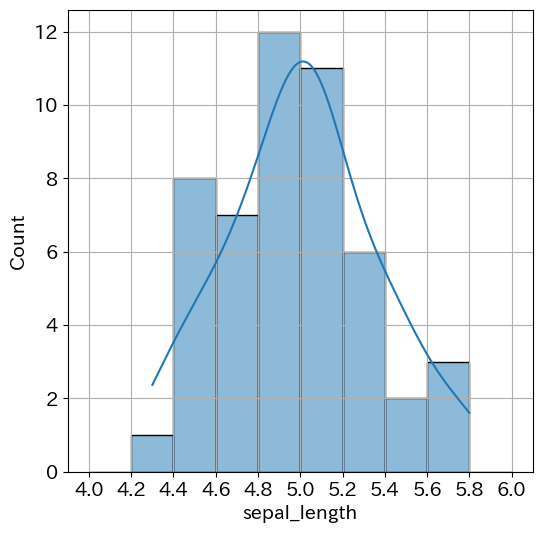

In [7]:
# setosaの行のみ抽出
df1 = df.query('species == "setosa"')

bins = np.arange(4.0, 6.2, 0.2)
# ヒストグラムを描画
sns.histplot(df1, x='sepal_length', bins=bins, kde=True)
plt.xticks(bins);

#### 変数Xの抽出と値の確認

In [8]:
# sepal_length列の抽出
s1 = df1['sepal_length']

# NumPy変数の1次元配列に変換
X = s1.values

# 統計情報の確認
print(s1.describe())

# 値の確認
print(X)

count   50.000
mean     5.006
std      0.352
min      4.300
25%      4.800
50%      5.000
75%      5.200
max      5.800
Name: sepal_length, dtype: float64
[5.100 4.900 4.700 4.600 5.000 5.400 4.600 5.000 4.400 4.900 5.400 4.800
 4.800 4.300 5.800 5.700 5.400 5.100 5.700 5.100 5.400 5.100 4.600 5.100
 4.800 5.000 5.000 5.200 5.200 4.700 4.800 5.400 5.200 5.500 4.900 5.000
 5.500 4.900 4.400 5.100 5.000 4.500 4.400 5.000 5.100 4.800 5.100 4.600
 5.300 5.000]


### 5.1.3 確率モデル定義

#### 確率モデル定義

In [9]:
model1 = pm.Model()

with model1:
  mu = pm.Normal('mu',mu=0.0, sigma=10.0)
  sigma = pm.HalfNormal('sigma', sigma=10.0)
  X_obs = pm.Normal('X_obs', mu=mu, sigma=sigma, observed=X)

#### 確率モデル構造可視化

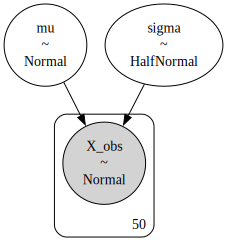

In [10]:
g = pm.model_to_graphviz(model1)
display(g)

### 5.1.4 サンプリング

In [11]:
with model1:
    idata1 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


### 5.1.5 結果分析

#### plot_trace関数による分析

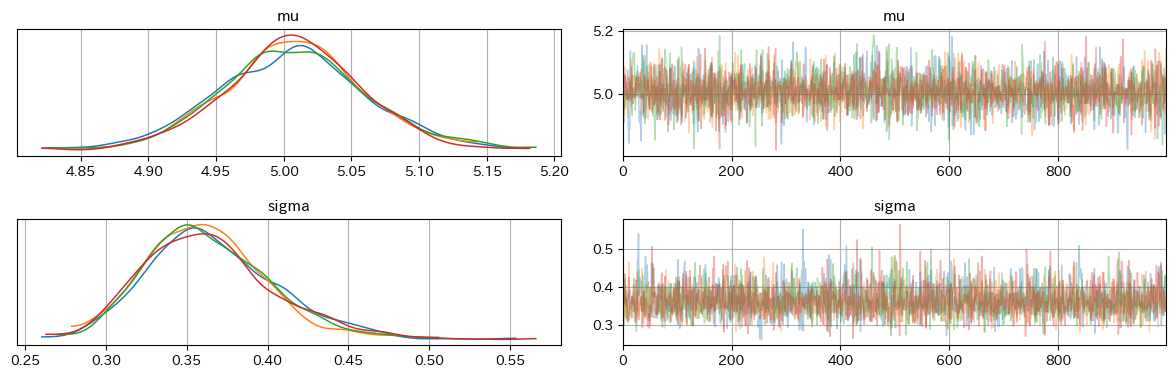

In [12]:
az.plot_trace(idata1, compact=False)
plt.tight_layout();

#### idata直接確認

In [13]:
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

#### plot_posterior関数による分析

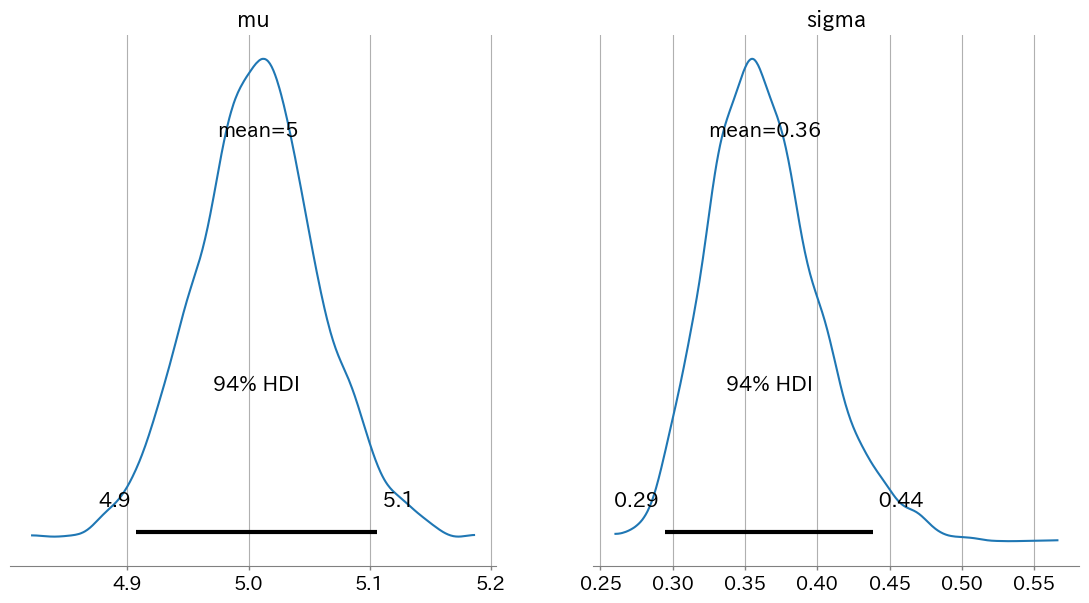

In [14]:
az.plot_posterior(idata1);

#### sumamry関数による統計分析

In [15]:
summary1 = az.summary(idata1)
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.007,0.053,4.907,5.106,0.001,0.001,4014.000,2240.000,1.000
sigma,0.364,0.039,0.295,0.439,0.001,0.000,3647.000,2708.000,1.000


#### 各確率変数の平均値取得

In [16]:
mu_mean1 = summary1.loc['mu','mean']
sigma_mean1 = summary1.loc['sigma','mean']

# 結果確認
print(f'mu={mu_mean1}, sigma={sigma_mean1}')

mu=5.007, sigma=0.364


### 5.1.6 正規分布関数とヒストグラムの重ね描き

#### 正規分布関数

In [17]:
def norm(x, mu, sigma):
    y = (x-mu)/sigma
    a = np.exp(-(y**2)/2)
    b = np.sqrt(2*np.pi)*sigma
    return a/b

#### ベイズ推論結果に基づく関数値計算

In [18]:
x_min = X.min()
x_max = X.max()
x_list = np.arange(x_min, x_max, 0.01)
y_list = norm(x_list, mu_mean1, sigma_mean1)

#### ベイズ推論結果に基づく正規分布関数とKDE曲線の重ね描き

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


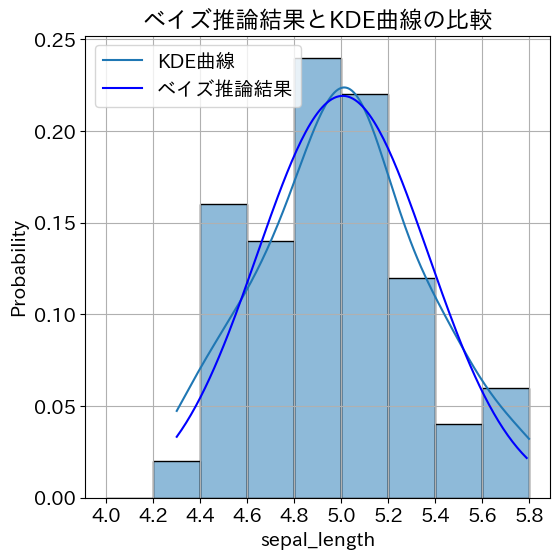

In [19]:
delta = 0.2
bins=np.arange(4.0, 6.0, delta)
fig, ax = plt.subplots()
sns.histplot(df1, ax=ax, x='sepal_length',
    bins=bins, kde=True, stat='probability')
ax.get_lines()[0].set_label('KDE曲線')
ax.set_xticks(bins)
ax.plot(x_list, y_list*delta, c='b', label='ベイズ推論結果')
ax.set_title('ベイズ推論結果とKDE曲線の比較')
plt.legend();

### 5.1.7 少ないサンプル数でベイス推論

#### データの絞り込み

In [20]:
# 先頭の5件だけにする
X_less = X[:5]

# 結果確認
print(X_less)

# 統計値確認
print(pd.Series(X_less).describe())

[5.100 4.900 4.700 4.600 5.000]
count   5.000
mean    4.860
std     0.207
min     4.600
25%     4.700
50%     4.900
75%     5.000
max     5.100
dtype: float64


#### 確率モデル定義とサンプリング

In [21]:
model2 = pm.Model()

with model2:
    mu = pm.Normal('mu', mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal('sigma', sigma=10.0)
    X_obs = pm.Normal('X_obs', mu=mu, sigma=sigma, observed=X_less)

    # サンプリング
    idata2 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


#### サンプリング結果の可視化

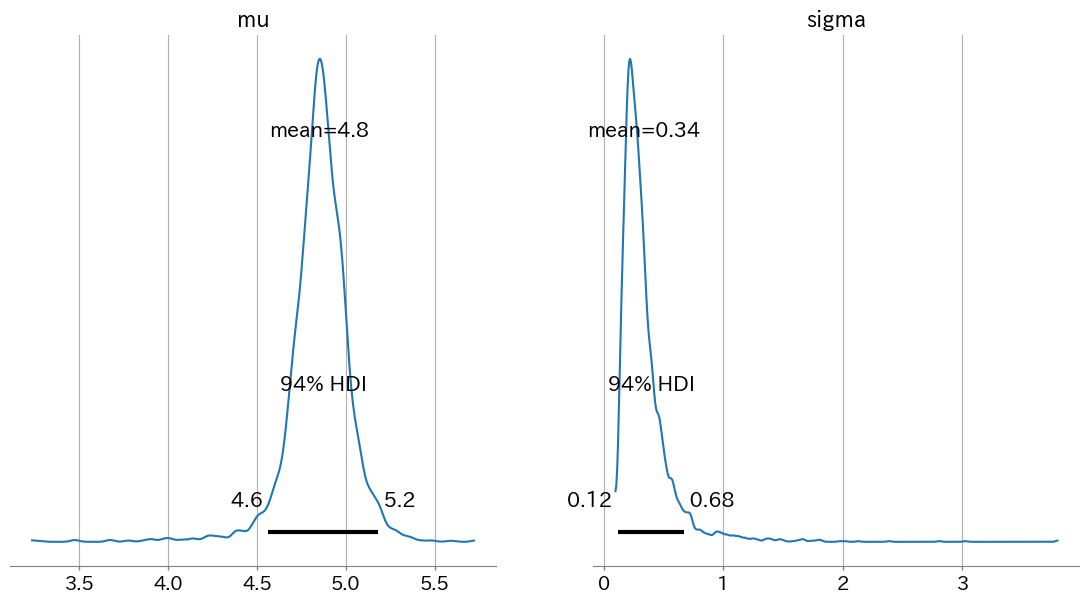

In [22]:
az.plot_posterior(idata2);

#### サンプリング結果の統計分析

In [23]:
summary2 = az.summary(idata2)
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.849,0.178,4.562,5.182,0.007,0.005,1100.000,611.000,1.000
sigma,0.337,0.224,0.116,0.675,0.008,0.006,1053.000,977.000,1.000


### コラム　tauによる確率モデルの定義

#### 確率モデル定義とサンプリング

In [24]:
model3 = pm.Model()

with model3:
    mu = pm.Normal('mu', mu=0.0, sigma=10.0)
    tau = pm.HalfNormal('tau', sigma=10.0)
    X_obs = pm.Normal('X_obs', mu=mu, tau=tau, observed=X)
    sigma = pm.Deterministic('sigma', 1/pm.math.sqrt(tau))

    # サンプリング
    idata3 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


#### サンプリング結果の可視化

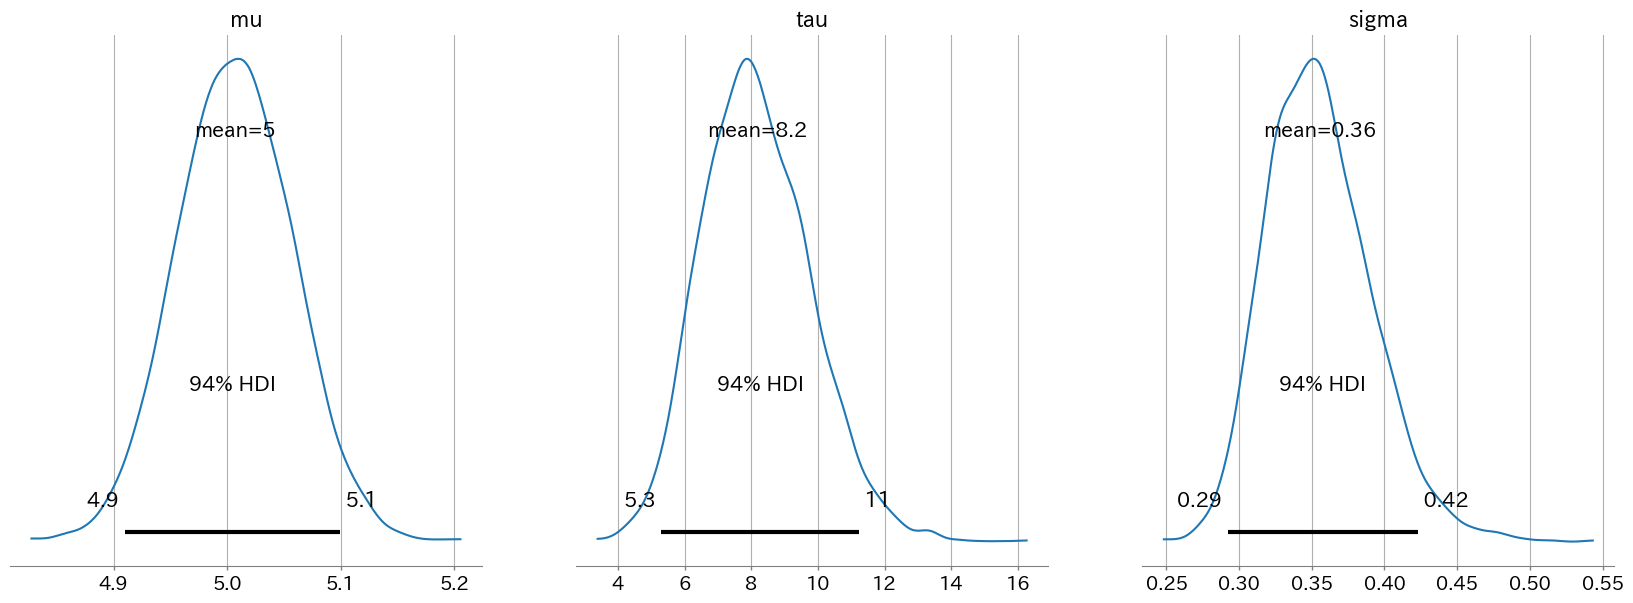

In [25]:
az.plot_posterior(idata3);

#### バージョンの確認

In [26]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

matplotlib         : 3.8.3
pandas             : 2.2.1
japanize_matplotlib: 1.1.3
seaborn            : 0.12.2
arviz              : 0.17.1
pymc               : 5.11.0
numpy              : 1.26.4

